## 1. Importing Libraries

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from resnets_utils import *
from torch.utils.data import random_split

%matplotlib inline
np.random.seed(1)


## 2. Loading Datasets

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

## 3. Visualize a sample

y = 5


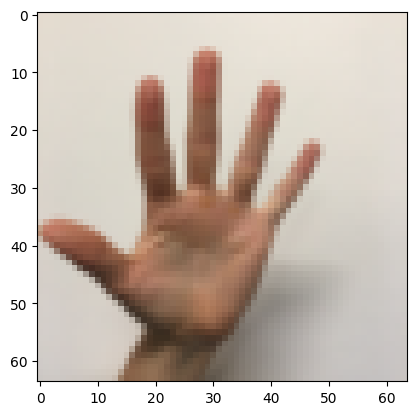

In [62]:
index = 3
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

## 4. Preprocess Data
This cell normalizes image data and converts it to the format required for model training. Images are scaled to [0, 1], reshaped, and converted to tensors. Labels are flattened and converted to tensor format.

In [ ]:
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

Y_train = Y_train_orig.flatten()
Y_test = Y_test_orig.flatten()

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.transpose(0,3,1,2), dtype=torch.float32)  # (m, C, H, W)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.transpose(0,3,1,2), dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# 80% for training and 20% for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for each
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"X_train shape: {X_train_tensor.shape}")
print(f"Y_train shape: {Y_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"Y_test shape: {Y_test_tensor.shape}")

X_train shape: torch.Size([1080, 3, 64, 64])
Y_train shape: torch.Size([1080])
X_test shape: torch.Size([120, 3, 64, 64])
Y_test shape: torch.Size([120])



## 5. IdentityBlock (ResNet Building Block),
This class implements the identity block used in ResNet architectures. The identity block allows the input to bypass several convolutional layers via a shortcut connection, enabling better gradient flow and deeper networks.,
- **Initialization:**,
- Takes input channels, filter sizes, and kernel size.,
- Defines three convolutional layers, each followed by batch normalization.,
- Uses ReLU activation after each convolution.,
- Asserts that the input and output channels match for the shortcut connection.,
- **Forward Pass:**,
- The input (`x`) is saved as the shortcut.,
- The input passes through three convolutional layers with batch normalization and ReLU activations.,
- The output of the third convolution is added to the shortcut and passed through a final ReLU.\n,
- Returns the result, preserving the identity mapping.


In [129]:
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, f, filters):
        super().__init__()
        F1, F2, F3 = filters
        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(F1, F2, kernel_size=f, padding=f//2, bias=False)
        self.bn2 = nn.BatchNorm2d(F2)
        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(F3)
        self.relu = nn.ReLU(inplace=True)
        assert in_channels == F3, "IdentityBlock requires in_channels == F3"
    
    def forward(self, x):
        shortcut = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.relu(out + shortcut)
        return out



### 6. ConvolutionalBlock (ResNet Building Block)\n,
This class implements the convolutional block used in ResNet architectures. Unlike the identity block, the convolutional block allows for changes in the input dimensions via a learnable shortcut path.,
- **Initialization:**,
- Takes input channels, filter sizes, kernel size, and stride.,
- Defines three convolutional layers (main path), each followed by batch normalization and ReLU activation.,
- Defines a shortcut path with a 1x1 convolution and batch normalization to match dimensions.,
- **Forward Pass:**,
- The input (`x`) passes through the shortcut path to adjust dimensions.,
- The main path applies three convolutions with batch normalization and ReLU activations.,
- The output of the main path is added to the shortcut and passed through a final ReLU.,
- Returns the result, enabling residual learning even when input and output dimensions differ.

In [130]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, f, filters, s):
        super().__init__()
        F1, F2, F3 = filters

        # Main path
        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=s, bias=False)
        self.bn1   = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(F1, F2, kernel_size=f, padding=f//2, bias=False)
        self.bn2   = nn.BatchNorm2d(F2)
        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(F3)

        # Shortcut path
        self.shortcut_conv = nn.Conv2d(in_channels, F3, kernel_size=1, stride=s, bias=False)
        self.shortcut_bn = nn.BatchNorm2d(F3)
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        shortcut = self.shortcut_bn(self.shortcut_conv(x))
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.relu(out + shortcut)
        return out
        



## Step 6: Define ResNet50 Model
This cell defines the full ResNet50 model using the building blocks. The model consists of multiple convolutional and identity blocks, followed by average pooling and a fully connected layer for classification.

In [131]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000, in_channels=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer2 = nn.Sequential(
            ConvolutionalBlock(64, f=3, filters=(64,64,256), s=1),
            IdentityBlock(256, f=3, filters=(64,64,256)),
            IdentityBlock(256, f=3, filters=(64,64,256)),
        )
        self.layer3 = nn.Sequential(
            ConvolutionalBlock(256, f=3, filters=(128,128,512), s=2),
            IdentityBlock(512, f=3, filters=(128,128,512)),
            IdentityBlock(512, f=3, filters=(128,128,512)),
            IdentityBlock(512, f=3, filters=(128,128,512)),
        )
        self.layer4 = nn.Sequential(
            ConvolutionalBlock(512, f=3, filters=(256,256,1024), s=2),
            IdentityBlock(1024, f=3, filters=(256,256,1024)),
            IdentityBlock(1024, f=3, filters=(256,256,1024)),
            IdentityBlock(1024, f=3, filters=(256,256,1024)),
            IdentityBlock(1024, f=3, filters=(256,256,1024)),
            IdentityBlock(1024, f=3, filters=(256,256,1024)),
        )
        self.layer5 = nn.Sequential(
            ConvolutionalBlock(1024, f=3, filters=(512,512,2048), s=2),
            IdentityBlock(2048, f=3, filters=(512,512,2048)),
            IdentityBlock(2048, f=3, filters=(512,512,2048)),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, num_classes)

        # He init for convs; standard BN/Linear init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.zeros_(m.bias)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


## Step 7: Set Hyperparameters
This cell sets important hyperparameters such as the number of output classes and training epochs. These values control the model's output and training duration.

In [136]:
YOUR_CLASSES = 6
num_epochs = 20

## Step 8: Initialize Model, Optimizer, and Loss Function
This cell initializes the ResNet50 model, sets the device (CPU or GPU), and defines the optimizer and loss function for training.

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(num_classes=YOUR_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [138]:
from sklearn.metrics import f1_score

## Step 10: Training Loop
This cell runs the training loop for the specified number of epochs. For each epoch, the model is trained on the training data and evaluated on the validation set. Accuracy and F1 score are printed for each epoch to monitor performance.

In [139]:
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:    # DataLoader returning (N,3,H,W), (N,)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            pred = logits.argmax(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'macro' for unweighted
    print(f"epoch {epoch + 1}: val acc = {correct/total:.3f}, val F1 = {f1:.3f}")

epoch 1: val acc = 0.199, val F1 = 0.106
epoch 2: val acc = 0.690, val F1 = 0.678
epoch 3: val acc = 0.556, val F1 = 0.537
epoch 4: val acc = 0.699, val F1 = 0.699
epoch 5: val acc = 0.671, val F1 = 0.685
epoch 6: val acc = 0.787, val F1 = 0.794
epoch 7: val acc = 0.801, val F1 = 0.792
epoch 8: val acc = 0.838, val F1 = 0.836
epoch 9: val acc = 0.843, val F1 = 0.839
epoch 10: val acc = 0.880, val F1 = 0.878
epoch 11: val acc = 0.792, val F1 = 0.787
epoch 12: val acc = 0.829, val F1 = 0.824
epoch 13: val acc = 0.792, val F1 = 0.787
epoch 14: val acc = 0.852, val F1 = 0.853
epoch 15: val acc = 0.778, val F1 = 0.781
epoch 16: val acc = 0.889, val F1 = 0.886
epoch 17: val acc = 0.866, val F1 = 0.863
epoch 18: val acc = 0.898, val F1 = 0.897
epoch 19: val acc = 0.917, val F1 = 0.917
epoch 20: val acc = 0.907, val F1 = 0.905


## Step 11: Test Evaluation
This cell evaluates the trained model on the test set, computing accuracy and F1 score. This provides a final measure of the model's generalization performance.

In [140]:
model.eval()
correct = total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        pred = logits.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (pred == labels).sum().item()
        total += labels.size(0)
test_acc = correct / total
from sklearn.metrics import f1_score
test_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Test accuracy: {test_acc:.3f}, Test F1: {test_f1:.3f}")

Test accuracy: 0.942, Test F1: 0.940


## Step 12: Visualize Training and Test Samples
This cell displays several images from both the training and test sets, along with their class labels. This helps visually inspect the data and verify class assignments.

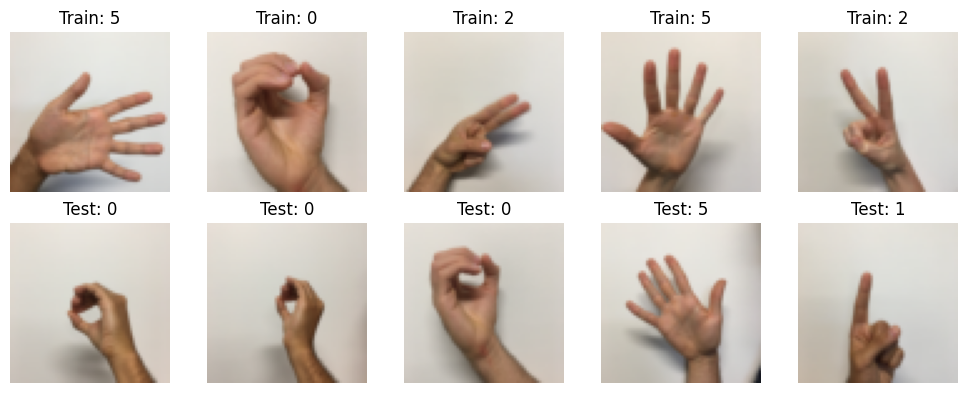

In [141]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Number of samples to show
n_train = 5
n_test = 5

fig, axes = plt.subplots(2, n_train, figsize=(2*n_train, 4))
for i in range(n_train):
    axes[0, i].imshow(X_train_orig[i])
    label = Y_train_orig[:, i].item() if hasattr(Y_train_orig[:, i], 'item') else int(Y_train_orig[:, i])
    axes[0, i].set_title(f"Train: {classes[label]}")
    axes[0, i].axis('off')
for i in range(n_test):
    axes[1, i].imshow(X_test_orig[i])
    label = Y_test_orig[:, i].item() if hasattr(Y_test_orig[:, i], 'item') else int(Y_test_orig[:, i])
    axes[1, i].set_title(f"Test: {classes[label]}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()